# Tutorial


## Example in 2D Uniform Distribution

This example generates a 2D random uniform distribution, and then uses GriSPy to search neighbors within a given radius and/or the n-nearest neighbors

----------------------------------------------------------------

### Import GriSPy and others packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from grispy import GriSPy

In [2]:
%matplotlib inline

### Create random points and centres

In [3]:
Npoints = 10 ** 3
Ncentres = 2
dim = 2
Lbox = 100.0

np.random.seed(0)
data = np.random.uniform(0, Lbox, size=(Npoints, dim))
centres = np.random.uniform(0, Lbox, size=(Ncentres, dim))

### Build the grid with the data

In [4]:
gsp = GriSPy(data)

Set periodicity. Periodic conditions on x-axis (or axis=0) and y-axis (or axis=1)

In [5]:
periodic = {0: (0, Lbox), 1: (0, Lbox)}
gsp.set_periodicity(periodic)

GriSPy(N_cells=20, periodic={0: (0, 100.0), 1: (0, 100.0)}, metric='euclid', copy_data=False)

Also you can build a periodic grid in the same step

In [6]:
gsp = GriSPy(data, periodic=periodic)

### Query for neighbors within upper_radii

In [7]:
upper_radii = 10.0
bubble_dist, bubble_ind = gsp.bubble_neighbors(
    centres, distance_upper_bound=upper_radii
)

### Query for neighbors in a shell within lower_radii and upper_radii

In [8]:
upper_radii = 10.0
lower_radii = 8.0
shell_dist, shell_ind = gsp.shell_neighbors(
    centres,
    distance_lower_bound=lower_radii,
    distance_upper_bound=upper_radii
)

### Query for nth nearest neighbors

In [9]:
n_nearest = 10
near_dist, near_ind = gsp.nearest_neighbors(centres, n=n_nearest)

### Plot results

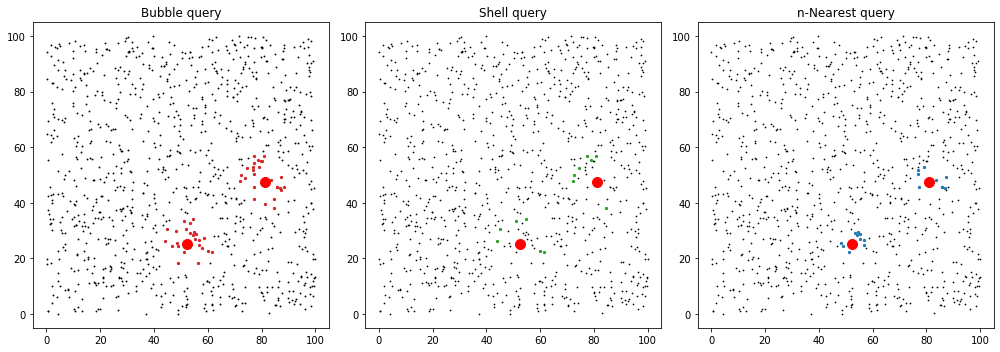

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

ax = axes[0]
ax.set_title("Bubble query")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=3)
for ind in bubble_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C3", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)


ax = axes[1]
ax.set_title("Shell query")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=2)
for ind in shell_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C2", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)

ax = axes[2]
ax.set_title("n-Nearest query")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=2)
for ind in near_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C0", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)

fig.tight_layout()

## Creating your curstom distance function

Let's assume that we intend to compare our distances using levenshtein's metric for similarity between text (https://en.wikipedia.org/wiki/Levenshtein_distance).

Luckly we have the excellent `textdistance` library that implements efficiently this distance. 

We can install it with

``` bash
$ pip install textdistance
```

and then import it with

In [11]:
import textdistance

So to make these custom distance compatible with GriSPy, we must define a function
that receives 3 parameters:
    
- `c0` the center to which we seek the distance.
- `centres` the $C$ centers to which we want to calculate the distance from
   a *c0*.
- `dim` the dimension of each center and *c0*.

Finally the function must return a `np.ndarray` with $C$ elements
where the element $j-nth$ corresponds to the distance between `c0` and `centres`$_j$.

In [12]:
def levenshtein(c0, centres, dim):
    # textdistance only operates over list and tuples
    c0 = tuple(c0)
    
    # creates a empty array with the required 
    # number of distances
    distances = np.empty(len(centres))
    for idx, c1 in enumerate(centres):
        
        # textdistance only operates over list and tuples
        c1 = tuple(c1)
        
        # calculate the distance
        dis = textdistance.levenshtein(c0, c1)
        
        # store the distance
        distances[idx] = dis
        
    return distances

Then we create the grid with the custom distance, and run the code

In [13]:
gsp = GriSPy(data, metric=levenshtein)

upper_radii = 10.0
lev_dist, lev_ind = gsp.bubble_neighbors(
    centres, distance_upper_bound=upper_radii)

Finally we can check our `bubble_neighbors` result with a plot

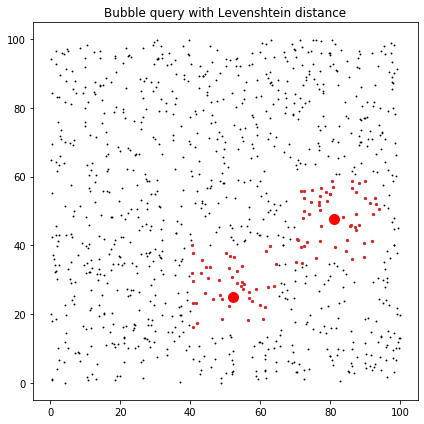

In [14]:
fig, axes = plt.subplots(figsize=(6, 6))

ax = axes
ax.set_title("Bubble query with Levenshtein distance")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=3)
for ind in lev_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C3", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)

fig.tight_layout()